In [1]:
# Author: Morpheus Hsieh (morpheus.hsieh@gmail.com)

from __future__ import print_function, division  

import os, sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import shutil
import time
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Subset, DataLoader

import torchvision
from torchvision import datasets, models, transforms

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1


In [2]:
# # Parameters

# # Top level data directory.
# data_dir = r'D:\GitWork\ants_and_bees\processed'

# # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_name = "resnet"

# # Number of classes in the dataset
# num_classes = 2

# # Batch size for training (change depending on how much memory you have)
# batch_size = 4

# # Number of epochs to train for
# num_epochs = 25

# # Flag for feature extracting. 
# # When False, we finetune the whole model, when True we only update the reshaped layer params
# feature_extract = True

mean_imgnet = [0.485, 0.456, 0.406]
std_imgnet  = [0.229, 0.224, 0.225]

In [3]:
RawPath  = r'D:\GitWork\ants_and_bees\raw'
ProcessedPath = r'D:\GitWork\ants_and_bees\processed'

normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

trainSet = datasets.ImageFolder(os.path.join(ProcessedPath, 'train'), train_transform)
validSet = datasets.ImageFolder(os.path.join(ProcessedPath, 'valid'), valid_transform)

class_names = trainSet.classes
print('train classes: ', class_names)

class_indexes = trainSet.class_to_idx
print('class to index: ', class_indexes)

trainSize = len(trainSet)
validSize = len(validSet)
print('\ntrain size: ', trainSize)
print('valid size: ', validSize)

trainX, trainY = trainSet[0]
print('\nimage:\n', trainX)
print('label:', trainY)

sampleSet = Subset(trainSet, range(10))
for i, data in enumerate(sampleSet):
    print('\ni:',i+1)
    image, label = data
    print('image:', image)
    print('label:', label)  

train classes:  ['ants', 'bees']
class to index:  {'ants': 0, 'bees': 1}

train size:  244
valid size:  153

image:
 tensor([[[-0.7650, -0.7650, -0.7650,  ..., -0.6623, -0.6794, -0.6623],
         [-0.7650, -0.7479, -0.7650,  ..., -0.6452, -0.6623, -0.6452],
         [-0.7650, -0.7650, -0.7822,  ..., -0.6109, -0.6452, -0.6452],
         ...,
         [-0.5938, -0.5938, -0.5767,  ..., -0.6965, -0.6965, -0.6965],
         [-0.5938, -0.5938, -0.6109,  ..., -0.6794, -0.6965, -0.7137],
         [-0.5938, -0.5938, -0.6109,  ..., -0.6794, -0.7137, -0.7308]],

        [[ 0.5903,  0.5903,  0.5903,  ...,  0.6954,  0.6779,  0.6954],
         [ 0.5903,  0.6078,  0.5903,  ...,  0.7129,  0.6954,  0.7129],
         [ 0.5903,  0.5903,  0.5903,  ...,  0.7479,  0.7129,  0.7129],
         ...,
         [ 0.8004,  0.8004,  0.8179,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.8004,  0.8004,  0.7829,  ...,  0.6779,  0.6604,  0.6429],
         [ 0.8004,  0.8004,  0.7829,  ...,  0.6779,  0.6429,  0.6254]],


In [4]:
BatchSize = 4
NumWorkers = 1

trainLoader = DataLoader(
        trainSet, batch_size=BatchSize, shuffle=True,  num_workers=NumWorkers
)

validLoader = DataLoader(
        validSet, batch_size=BatchSize, shuffle=False, num_workers=NumWorkers
)

train images shape:  torch.Size([4, 3, 224, 224])
train classes shape:  torch.Size([4])


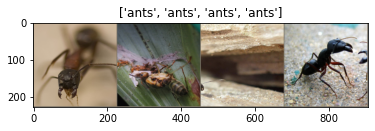

In [5]:
# Imshow for Tensor
def imshow(inp, title=None):
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
images, classes = next(iter(trainLoader))
print('train images shape: ', images.shape)
print('train classes shape: ', classes.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# Model finetune
def model_finetune(class_names):
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features 
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))
    return model_ft

model_ft = model_finetune(class_names).to(device)
print(model_ft) 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def train(model, loader, device, optimizer, criterion, datasize, scheduler):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
            
        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    scheduler.step()
        
    epoch_loss = running_loss / datasize
    epoch_acc = running_corrects.double() / datasize
        
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
    return

In [9]:
def valid(model, loader, device, optimizer, criterion, datasize, best_model_wts, best_acc):
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / datasize
    epoch_acc = running_corrects.double() / datasize
        
    print('Valid Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
    # deep copy the model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    return best_acc, best_model_wts

In [10]:
# loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
lr = 0.001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Total Epochs
num_epochs = 25

# Train and Valid
since = time.time()
print('\nTraining start...')

best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0
    
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 30)
    
    train(
        model_ft, trainLoader, device, optimizer_ft, criterion, trainSize, exp_lr_scheduler
    )
    
    best_acc, best_model_wts = valid(
        model_ft, validLoader, device, optimizer_ft, criterion, validSize, best_model_wts, best_acc
    )
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model_ft.load_state_dict(best_model_wts)


Training start...
Epoch 0/24
------------------------------
Train Loss: 0.6048 Acc: 0.6639
Valid Loss: 0.1960 Acc: 0.9281

Epoch 1/24
------------------------------
Train Loss: 0.3227 Acc: 0.8811
Valid Loss: 0.2218 Acc: 0.9281

Epoch 2/24
------------------------------
Train Loss: 0.5074 Acc: 0.8115
Valid Loss: 0.3477 Acc: 0.8758

Epoch 3/24
------------------------------
Train Loss: 0.4708 Acc: 0.8074
Valid Loss: 0.1894 Acc: 0.9477

Epoch 4/24
------------------------------
Train Loss: 0.6149 Acc: 0.7705
Valid Loss: 0.2872 Acc: 0.9150

Epoch 5/24
------------------------------
Train Loss: 0.4659 Acc: 0.8566
Valid Loss: 0.3993 Acc: 0.8301

Epoch 6/24
------------------------------
Train Loss: 0.4477 Acc: 0.8320
Valid Loss: 0.3042 Acc: 0.9020

Epoch 7/24
------------------------------
Train Loss: 0.4676 Acc: 0.8197
Valid Loss: 0.3184 Acc: 0.8889

Epoch 8/24
------------------------------
Train Loss: 0.3166 Acc: 0.8525
Valid Loss: 0.2313 Acc: 0.9150

Epoch 9/24
-------------------------

<All keys matched successfully>

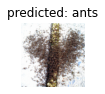

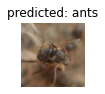

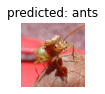

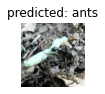

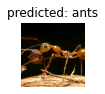

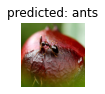

In [17]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(model_ft)        